This is the first notebook from version 3 of the fast.ai course! For more information you can visit https://www.fast.ai/.

# Lesson 1 - What's your pet

In this lesson we will build our first image classifier from scratch, and see if we can achieve world-class results. Let's dive in!

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [2]:
from fastai import *
from fastai.vision import *

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [3]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

In [4]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True) -> pathlib.Path
    Download `url` to `fname` if it doesn't exist, and un-tgz to folder `dest`.



In [5]:
URLs.PETS

'https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet'

In [6]:
path = untar_data(URLs.PETS); path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [7]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [8]:
path_anno = path/'annotations'
path_img = path/'images'

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

We use the `get_image_files` function to grab an array of all the images based on the extension in a path.

In [9]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/beagle_115.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/boxer_18.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Maine_Coon_157.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/scottish_terrier_28.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/english_setter_6.jpg')]

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

`ImageDataBunch` is an object that represents all the data you need to build a model. A `DataBunch` object contains 2 or 3 datasets: training data, validation data and optionally test data. For each dataset it contains the data (images or texts or tabular data) and their labels.

In [10]:
np.random.seed(2)
pat = re.compile(r'/([^/]+)_\d+.jpg$')

Read [this](https://www.sharpsightlabs.com/blog/numpy-random-seed/) to understand np.random.seed.

In [11]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs, num_workers=0
                                  ).normalize(imagenet_stats)

`size` specifies the size images we want to work with. Although the images have a size, a GPU has to apply the exact same instruction to all images in order to be fast. If the images are different shapes and sizes, it can't do that. So we have to make all the images the exact shape and size. `224 by 224` is a common size that most models tend to use. If the image size is not `224`, `get_transforms` makes the image size `224` through a combination of cropping and resizing.

`normalize` is used to normalize the pixel values (0 to 255) of the channels (channels are red, green and blue) so that every channel has a mean of 0 and standard deviation of 1. If data is not normalized, it can be difficult to train well.

We use `show_bath` to look at our data.

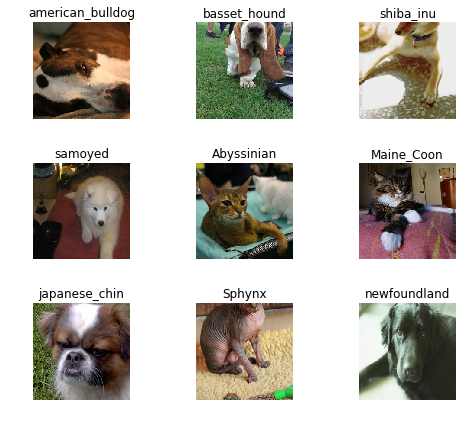

In [12]:
data.show_batch(rows=3, figsize=(7,6))

We also want to look at the labels. All of the possible label names are called our `classes`. `data.classes` gives an array of the classes and `data.c` gives the number of classes.

In [13]:
print(data.classes)
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

We will use the `ResNet34` model. `ResNet34` was trained on looking at about one and a half million pictures of all kinds of different things, a thousand categories of things, using an image dataset called ImageNet. So we can download those pre-trained weights so that we don't start with a model that knows nothing about anything, but we actually start with a model that knows how to recognize a thousand categories of things in ImageNet. `ResNet34` may not have all 37 categories but it definitely contains some kind some of dog and some kinds of cat. So this pre-trained model knows quite a little bit about what pets look like, and it certainly knows quite a lot about what animals look like and what photos look like.

So the idea is that we don't start with a model that knows nothing at all, but we start by downloading a model that knows something about recognizing images already. This is the concept of `Transfer Learning`.

`Transfer Learning` involves taking a model that already knows how to do something pretty well and make it so that it can do your thing really well. We will take a pre-trained model, and then we fit it so that instead of predicting a thousand categories of ImageNet with ImageNet data, it predicts the 37 categories of pets using your pet data. By doing this, you can train models in 1/100 or less of the time of regular model training with 1/100 or less of the data of regular model training. Potentially, many thousands of times less.

In [14]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 55943490.12it/s]


`metrics` such as `error_rate` get printed out automatically using the validation set. A validation set is a set of images that your model does not get to look at. A validation set prevents `overfitting`, a situation where you don't learn to recognize pictures of say cricket versus baseball, but just the particular cricketers in the particular cricket photos and the particular baseball players in the particular baseball photos. We have to avoid overfitting.

We now fit our convoluted neural network using `fit_one_cyle`. The number, 4, basically decides how many times do we go through the entire dataset, how many times do we show the dataset to the model so that it can learn from it. Each time it sees a picture, it's going to get a little bit better. But it's going to take time and it means it could overfit. If it sees the same picture too many times, it will just learn to recognize that picture, not pets in general.

In [15]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,1.369974,0.323478,0.090663
2,0.561296,0.257050,0.074425
3,0.347152,0.211134,0.064276
4,0.261459,0.206875,0.063599


After 4 epochs, we have an `error_rate` as a percentage. If the error rate is 6%, it means that 94% of the time we correctly picked the exact dog or cat breed.

In [16]:
learn.save('stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

To see what comes out, we use `ClassificationInterpretation` for class interpretation. We are going to use the factory method `from_learner`, so we pass in a `learn` object which knows two things:

    What is our data.
    What is our model. Now it's not just an architecture, it's actually a trained model.

That's all the information we need to interpret that model.

In [17]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

A loss function is something that tells you how good was your prediction. Specifically that means if you predicted one class of cat with great confidence, but actually you were wrong, then that's going to have a high loss because you were very confident about the wrong answer.

Using `plot_top_losses`, we are going to find out what were the things that we were the most wrong on, or the most confident about what we got wrong.

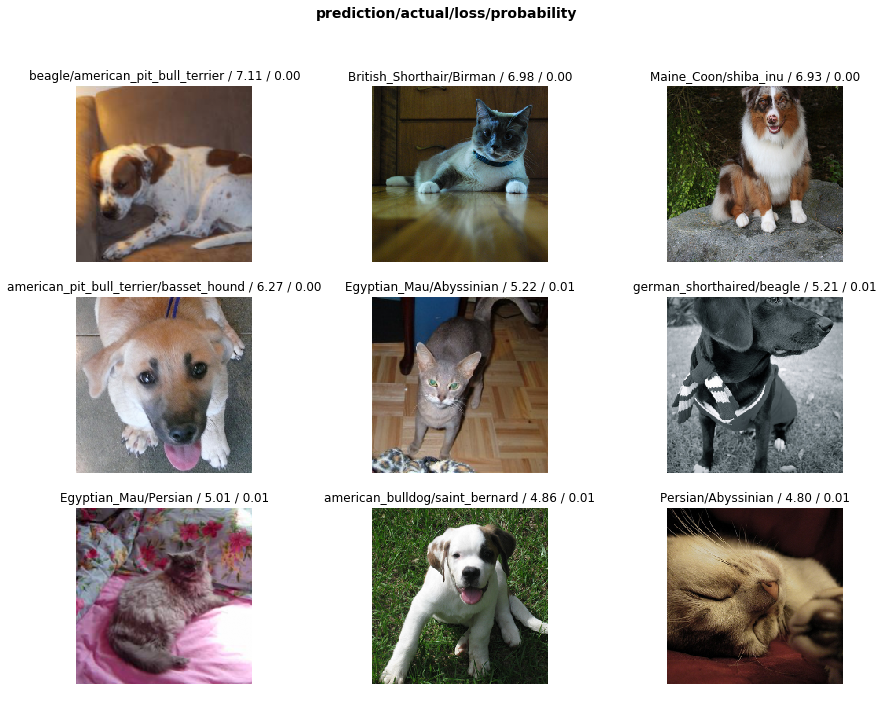

In [18]:
interp.plot_top_losses(9, figsize=(15,11))

You can view the docs for `plot_top_losses` by running the code below and then clicking on the `Show in docs` link.

In [19]:
doc(interp.plot_top_losses)

A `confusion matrix` basically shows us for every actual type of dog or cat, how many times was it predicted to be that dog or cat. But unfortunately, in this case, because it's so accurate, this diagonal basically says how it's pretty much right all the time. 

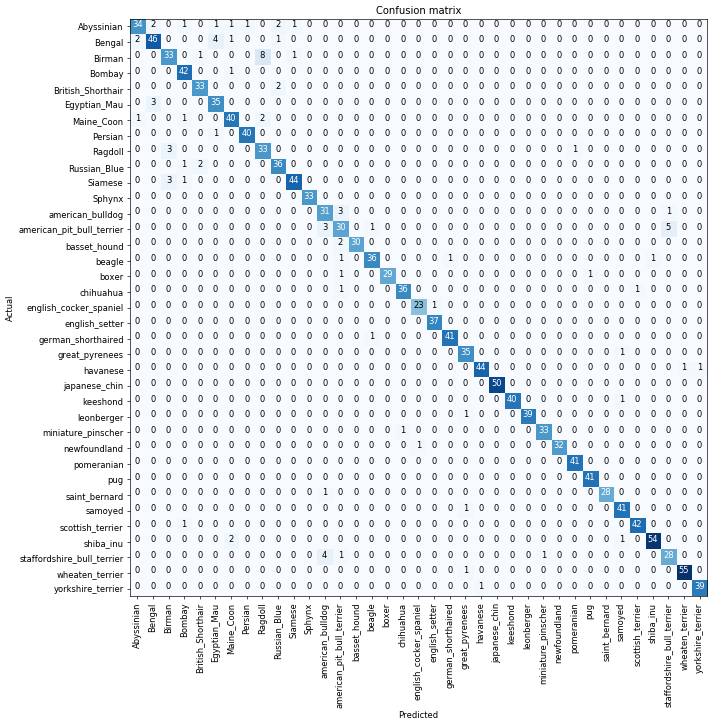

In [20]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

If there are lots of classes, it is better to use `most_confused` instead of a confusion matrix. `most_confused` will simply grab out of the confusion matrix the particular combinations of predicted and actual that got wrong the most often.

In [21]:
interp.most_confused(min_val=2)

[('Birman', 'Ragdoll', 8),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 5),
 ('Bengal', 'Egyptian_Mau', 4),
 ('staffordshire_bull_terrier', 'american_bulldog', 4),
 ('Egyptian_Mau', 'Bengal', 3),
 ('Ragdoll', 'Birman', 3),
 ('Siamese', 'Birman', 3),
 ('american_bulldog', 'american_pit_bull_terrier', 3),
 ('american_pit_bull_terrier', 'american_bulldog', 3)]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

We fitted 4 epochs and it ran pretty quickly. These convolutional networks have many layers so it goes through a lot of computations. The reason it ran pretty quickly is because we added a few extra layers to the end and we only trained those. We basically left most of the model exactly as it was, so that's really fast. If we are trying to build a model at something that's similar to the original pre-trained model (in this case, similar to the ImageNet data), that works pretty well.

What we really want to do is to go back and train the whole model. By default, when we call `fit` or `fit_one_cycle` on a `create_cnn`, it'll just fine-tune these few extra layers added to the end and it will run very fast. It will basically never overfit but to really get it good, we have to call `unfreeze`. `unfreeze` is the thing that says please train the whole model. Then we can call `fit_one_cycle` again.

In [22]:
learn.unfreeze()

In [23]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate
1,0.523308,0.308844,0.100812


The `error_rate` is now higher and the reason is explained [here](https://youtu.be/BWWm4AzsdLk?t=4588). Our attempt to fine-tune this model didn't work because by default, it trains all the layers at the same speed which is to say it will update those things representing diagonal lines and gradients just as much as it tries to update the things that represent the exact specifics of what an eyeball looks like, so we have to change that.

To change it, we first of all need to go back to where we were before. We just broke this model, making it much worse than it started out.

In [24]:
learn.load('stage-1');

Our model is back to where it was before we ruined it.

The learning rate finder, `lr_find`, is the thing that figures out what is the fastest I can train this neural network at without making it zip off the rails and get blown apart.

In [25]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


We can then plot the result of our learning rate finder. 

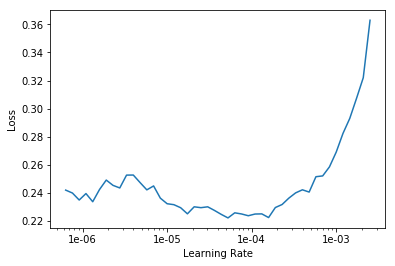

In [26]:
learn.recorder.plot()

This graph basically shows us the key parameter called a learning rate. The learning rate basically says how quickly am I updating the parameters in my model. The x-axis one here shows what happens as we increase the learning rate. The y axis show what the loss is. So you can see, once the learning rate gets passed 1e^-4, our loss gets worse. The learning rate default is 0.003.

Because we are trying to fine-tune things now, we can't use such a high learning rate. So based on the learning rate finder, we try to pick something well before it started getting worse, `1e-6`. But there's no point training all the layers at that rate, because we know that the later layers worked just fine before when we were training much more quickly (at the learning rate of 0.003). So what we can actually do is we can pass a range of learning rates to `learn.fit_one_cycle`.

What this says is train the very first layers at a learning rate of `1e-6`, and the very last layers at a rate of `1e-4`, and distribute all the other layers across that (i.e. between those two values equally).

In [27]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.230601,0.203727,0.066306
2,0.202817,0.196834,0.062246


That's a pretty accurate model!

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [28]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2, num_workers=0).normalize(imagenet_stats)

In [29]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 57503851.93it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


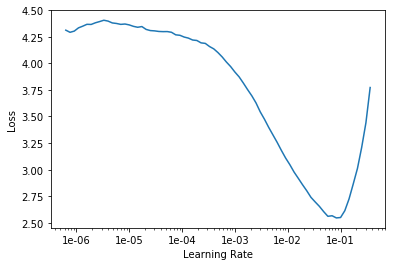

In [30]:
learn.lr_find()
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate
1,0.707767,0.287241,0.094723
2,0.385624,0.265357,0.088633
3,0.358151,0.236047,0.085927
4,0.267640,0.199174,0.069689
5,0.214847,0.169373,0.063599
6,0.149154,0.153295,0.055480
7,0.120849,0.142799,0.053451
8,0.090787,0.141239,0.052774


In [32]:
learn.save('stage-1-50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [33]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.096763,0.149598,0.053451
2,0.095836,0.142109,0.049391
3,0.074142,0.139393,0.048714


If it doesn't, you can always go back to your previous model.

In [34]:
learn.load('stage-1-50');

In [35]:
interp = ClassificationInterpretation.from_learner(learn)

In [36]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 10),
 ('Ragdoll', 'Birman', 4),
 ('miniature_pinscher', 'chihuahua', 4),
 ('Birman', 'Ragdoll', 3),
 ('Egyptian_Mau', 'Bengal', 3),
 ('american_bulldog', 'american_pit_bull_terrier', 3),
 ('staffordshire_bull_terrier', 'american_bulldog', 3),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 3)]

## Other data formats

In [37]:
path = untar_data(URLs.MNIST_SAMPLE); path

PosixPath('/root/.fastai/data/mnist_sample')

In [38]:
path.ls()

[PosixPath('/root/.fastai/data/mnist_sample/valid'),
 PosixPath('/root/.fastai/data/mnist_sample/labels.csv'),
 PosixPath('/root/.fastai/data/mnist_sample/train')]

In [39]:
(path/'train').ls()

[PosixPath('/root/.fastai/data/mnist_sample/train/7'),
 PosixPath('/root/.fastai/data/mnist_sample/train/3')]

In [40]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26, num_workers=0)

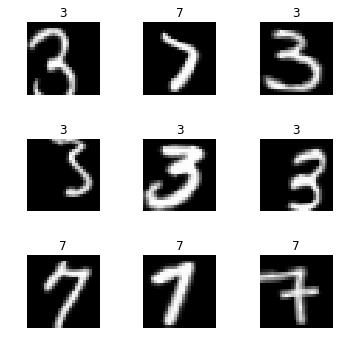

In [41]:
data.show_batch(rows=3, figsize=(5,5))

In [42]:
learn = create_cnn(data, models.resnet18, metrics=accuracy)
learn.fit(2)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 53312632.04it/s]


epoch,train_loss,valid_loss,accuracy
1,0.195822,0.085194,0.971050
2,0.134660,0.052834,0.982826


In [43]:
df = pd.read_csv(path/'labels.csv')
df.head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


In [44]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28, num_workers=0)

[0, 1]

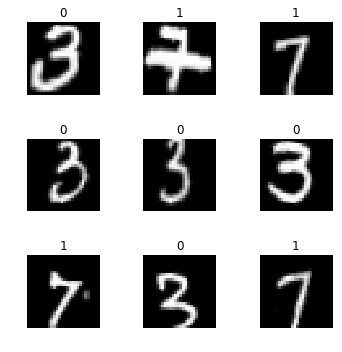

In [45]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [46]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24, num_workers=0)
data.classes

[0, 1]

In [47]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

[PosixPath('/root/.fastai/data/mnist_sample/train/3/7463.png'),
 PosixPath('/root/.fastai/data/mnist_sample/train/3/21102.png')]

In [48]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24, num_workers=0)
data.classes

['3', '7']

In [49]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7', num_workers=0)
data.classes

['3', '7']

In [50]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

['3', '3', '3', '3', '3']

In [51]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24, num_workers=0)
data.classes

['3', '7']